In [32]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, 'models')
sys.path.insert(0, 'utils')

# import tensorflow_hub as hub
# import tensorflow as tf
import numpy as np
import wandb
import matplotlib.pyplot as plt
import numpy as np
import torch
import argparse
from plotting_utils import plot_pytorch_images, make_grid
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from misc import merge
# import celebaHQ 
from dsvae_model import DSVAE, loss_function
from dsvae_model_mask import DSVAE_ADD
from datasets import DSVAE_DATA, VAE_DATA
from torch.nn import functional as F

from tempfile import mkdtemp
import os.path as path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
parser = argparse.ArgumentParser()
parser.add_argument("--num_datapoints", help="num datapoints", default=10000, type=int)
parser.add_argument("--z_dim", help="z dimension", default=85, type=int)
parser.add_argument("--device", help="gpu id", default=0, type=int)
parser.add_argument("--nb_epochs", help="number of epochs", default=500, type=int)
parser.add_argument("--start_epoch", help="epoch to start training from (requires checkpoints)", default=0, type=int)
parser.add_argument("--save_interval", help="epochs to save model", default=10, type=int)
parser.add_argument("--run_seed", help="run seed of TCVAE", default=100, type=int)
parser.add_argument("--lr", help="learning rate", default=.0001, type=float)
parser.add_argument("--resolution", help="resolution", default=128, type=int)
parser.add_argument("--batch_size", help="batch size", default=100, type=int)
parser.add_argument("--has_validation", help="If True, will use validation set", default=True, type=bool)
parser.add_argument("--validation_size", help="Validation set size", default=1000, type=int)


args = parser.parse_args([])

num_datapoints=args.num_datapoints
resolution = args.resolution

log = False
if log:
    wandb.init(project="dsvae_vae", name="celeba_{}_{}".format(num_datapoints, resolution))
    wandb.config.update(args)


device = torch.device("cuda:0" if (torch.cuda.is_available() and args.device > -1) else "cpu")
print("z_dim: {}".format(args.z_dim))
print("GPU: {}".format(device))
print("start_epoch: {}".format(args.start_epoch))
print("save_interval: {}".format(args.save_interval))

z_dim: 85
GPU: cuda:0
start_epoch: 0
save_interval: 10


In [27]:
dataroot="/hdd_c/sri/CelebA/128/"
validation_size = 0
if args.has_validation:
    validation_size = args.validation_size
num_samples = num_datapoints + validation_size

full_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(resolution),
                               transforms.CenterCrop(resolution),
                               transforms.ToTensor()
                           ]))

torch_dataset,torch_val_dataset,_ = torch.utils.data.random_split(full_dataset, [num_datapoints,validation_size,full_dataset.__len__()-num_samples])
print(full_dataset)
torch_data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)

if args.has_validation:
    torch_val_data_loader = torch.utils.data.DataLoader(torch_val_dataset, batch_size=args.batch_size, drop_last=True, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 30000
    Root location: /hdd_c/sri/CelebA/128/
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(128, 128))
               ToTensor()
           )


# Instantiating and Training DSVAE

In [37]:
# if device != -1 and device is not None:
#     dsvae = DSVAE(z_dim=85, y_shape=[3,256,256], input_shape=[3,256,256], device=args.device)
#     dsvae.to(device)
# else:
#     dsvae = DSVAE(z_dim=85, y_shape=[3,256,256], input_shape=[3,256,256], device=None)
if device != -1 and device is not None:
    print(device)
    dsvae = DSVAE_ADD(z_dim=85, y_shape=[3,resolution,resolution], device=args.device)
    dsvae.to(device)
else:
    dsvae = DSVAE_ADD(z_dim=85, y_shape=[3,resolution,resolution], device=None)
optimizer = torch.optim.Adam(params=dsvae.parameters(), lr=args.lr)

cuda:0
0


Training for 500 epochs...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


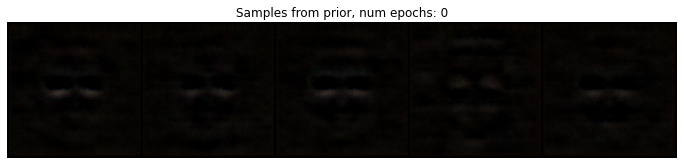

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


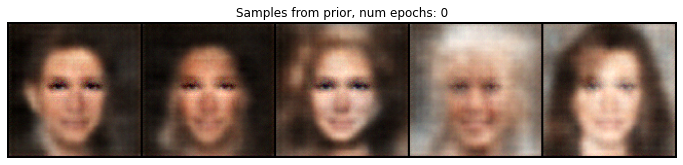

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


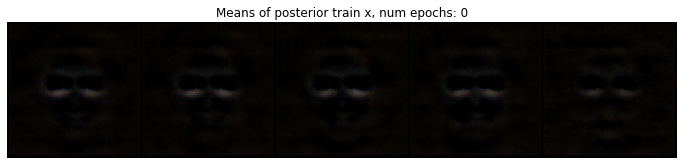

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


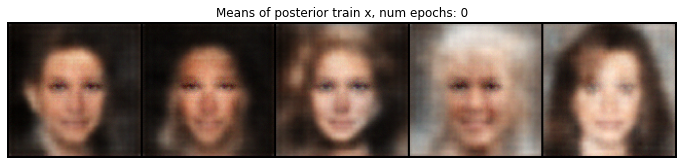

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


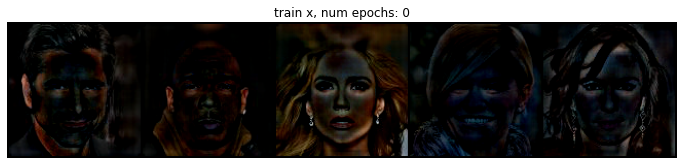

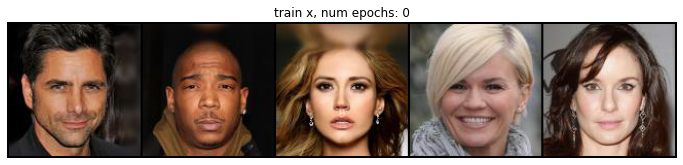

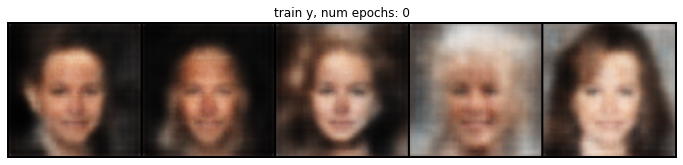

KeyboardInterrupt: 

In [41]:
dsvae.train()
normal = torch.distributions.Normal(0,1)
# reconstruction_function = torch.nn.BCELoss(reduction='sum')
reconstruction_function = torch.nn.MSELoss(reduction='sum')
print("Training for {} epochs...".format(500))
for n in range(0, 500):
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    num_examples = 0
    for (i, X) in enumerate(torch_data_loader):
        x = X[0]
        
        
        with torch.no_grad():
            vae_path = 'VAE_10K_64_HQ'
            vae = torch.load(vae_path)
            vae.to(device)   
            x_hat = torch.stack([transforms.Compose([transforms.ToPILImage(),
                        transforms.Resize(resolution//2),
                        transforms.ToTensor()
                       ])(x_i) for x_i in x])
  
            x_hat = x_hat.to(device)
            _, z_mu, z_var = vae(x_hat)
            z_sample = torch.distributions.Normal(z_mu, z_var).sample().to(device)
            y = vae.decode(z_sample)
            y = F.interpolate(y, size=[resolution, resolution], mode='bicubic')
            

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        x_mask_hat, z_mu, z_var = dsvae(x, y)
        x_hat = y + x_mask_hat
        x_mask = x - y
        loss, recon_loss, kl_loss = loss_function(x_mask_hat, x_mask, z_mu, z_var, reconstruction_function)
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        num_examples += x_hat.shape[0]
        loss.backward()
        optimizer.step()
    if log:
        wandb.log({'train_loss':train_loss/num_examples})
        wandb.log({'train_recon_loss':train_recon_loss/num_examples})
        wandb.log({'train_kl_loss':train_kl_loss/num_examples})


    if n%20 ==0:
        dsvae.eval() #evaluate model
        z_noise = normal.sample((x.shape[0],85))
        z_zeros = torch.zeros((x.shape[0],85))
        if dsvae.cuda:
            z_noise = z_noise.to(device)
            z_zeros = z_zeros.to(device)
        x_mask_hat_noise = dsvae.decode(z_noise, y)
        x_hat_noise = x_hat + x_mask_hat_noise

            
        fig = make_grid(x_mask_hat_noise[:5], num_images=5, title='Samples from prior, num epochs: {}'.format(n))
        if log:
            wandb.log({'Mask Samples from prior':fig})
            
        fig = make_grid(x_hat_noise[:5], num_images=5, title='Samples from prior, num epochs: {}'.format(n))
        if log:
            wandb.log({'X Samples from prior':fig}) 
            
        fig = make_grid(x_mask_hat[:5], num_images=5, title='Means of posterior train x, num epochs: {}'.format(n))
        if log:
            wandb.log({'Mask Means of posterior train x':fig})
            
        fig = make_grid(x_hat[:5], num_images=5, title='Means of posterior train x, num epochs: {}'.format(n))
        if log:
            wandb.log({'X Means of posterior train x':fig})
            
        fig = make_grid(x_mask[:5], num_images=5, title='train x, num epochs: {}'.format(n))
        if log:
            wandb.log({'train mask':fig})
            
        fig = make_grid(x[:5], num_images=5, title='train x, num epochs: {}'.format(n))
        if log:
            wandb.log({'train x':fig})

        fig = make_grid(y[:5], num_images=5, title='train y, num epochs: {}'.format(n))
        if log:
            wandb.log({'train y':fig})   
        
            
        dsvae.train() #back to training model